In [1]:
from PIL import Image, ImageStat
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from scipy.ndimage.filters import gaussian_filter
from sklearn.cluster import MeanShift, KMeans, estimate_bandwidth
from skimage.metrics import mean_squared_error
import matplotlib.pyplot as plt
import glob 
import random
import numpy as np
import os
import re
import cv2
import argparse
import pandas as pd
import math
import torch  
import torch.nn.functional as F 

/var/folders/n2/h_p1g87j4fx1l3clf8fzzls80000gn/T/ipykernel_68392/3357147910.py:5: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


### THE ONLY CELL BELOW: MODIFY VALUES TO CATER

In [2]:
image_dataset_name = 'fits'
change = '4_001_Wmse_02_ep1'

In [3]:
res_file_dir = 'result_data_'+image_dataset_name+'/'+change
result_plot_folder_name = 'result_plot_'+image_dataset_name

In [4]:
def extract_nonzero_rows(df):
    return df[(df != 0).any(axis=1)]

In [5]:
def load_valid_results(res_file_dir, metric):
    all_valid = []

    for i in range(5):
        file_path = os.path.join(res_file_dir, f"test_results_{metric}_all_{i}.csv")
        df = pd.read_csv(file_path, index_col=0)
        valid_rows = df[(df != 0).any(axis=1)]
        all_valid.append(valid_rows)

    all_valid = pd.concat(all_valid, axis=0, ignore_index=True)

    all_valid['kmean_metric'] = all_valid.mean(axis=1)

    all_valid = all_valid[['kmean_metric']]

    return all_valid

In [6]:
# combine non-zero values from different sets to one
combined_test_results_ssim = load_valid_results(res_file_dir, metric="ssim")
combined_test_results_sssim = load_valid_results(res_file_dir, metric="sssim")

### Visualize Test Set
### SSIM / SSSIM Comparison for all n-folds

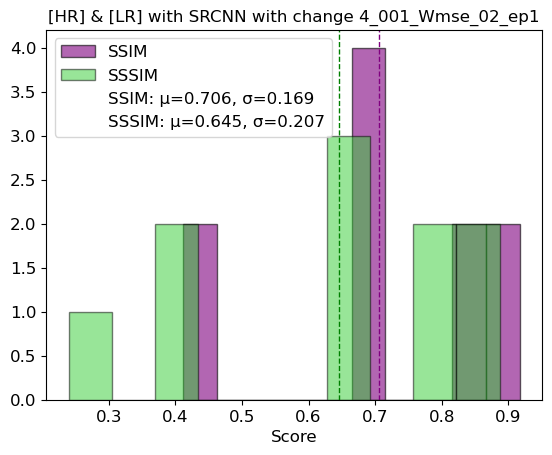

In [7]:
ssim_vals = combined_test_results_ssim['kmean_metric'].values
sssim_vals = combined_test_results_sssim['kmean_metric'].values

ssim_mean = np.mean(ssim_vals)
ssim_std = np.std(ssim_vals)
sssim_mean = np.mean(sssim_vals)
sssim_std = np.std(sssim_vals)

plt.figure()
plt.hist(ssim_vals, alpha=0.6, color='purple', edgecolor='black', label='SSIM')
plt.hist(sssim_vals, alpha=0.5, color='limegreen', edgecolor='black', label='SSSIM')

# plt.text(0.05, 1, f'SSIM: μ={ssim_mean:.3f}, σ={ssim_std:.3f}', fontsize=10, color='purple')
# plt.text(0.05, 0.5, f'SSSIM: μ={sssim_mean:.3f}, σ={sssim_std:.3f}', fontsize=10, color='green')
plt.plot([], [], ' ', label=f'SSIM: μ={ssim_mean:.3f}, σ={ssim_std:.3f}')
plt.plot([], [], ' ', label=f'SSSIM: μ={sssim_mean:.3f}, σ={sssim_std:.3f}')
plt.legend(loc='best', fontsize=10)

plt.axvline(ssim_mean, color='purple', linestyle='dashed', linewidth=1)
plt.axvline(sssim_mean, color='green', linestyle='dashed', linewidth=1)

plt.legend(fontsize=12)
plt.xlabel('Score', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.xlim(xmin=0, xmax=1)
plt.title("[HR] & [LR] with SRCNN with change "+change)

os.makedirs(result_plot_folder_name, exist_ok=True)
plt.savefig(os.path.join(result_plot_folder_name, 'ssim_'+change+'.png'))